In [1]:
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from sbpy.data import Ephem, Phys
from sbpy.activity import (Haser, LTE, NonLTE, photo_timescale, einstein_coeff, 
intensity_conversion, beta_factor, total_number, from_Haser)
import matplotlib.pyplot as plt
import matplotlib
import astropy.constants as con

LTE Production Rate without Photodissociation Effects
=============================
________________________________________________________________________________

`sbpy.spectroscopy` provides several models to calculate molecular production rates in comets. 

The LTE model in this notebook is based on [Drahus et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...756...80D/abstract). This model does not include photodissociation effects. For details on the model parameters that are optional or needed for all the sbpy.activity functions used in these examples refer to the Reference/API section of the [documentation](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#module-sbpy.activity), or look at the simple examples [given here](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#production-rate-calculations). This extremely simplified model is useful to calculate first guesses for more computationally intensive Non-LTE models or for LTE Haser models that include photodissociation.

The following examples test this simple version of the production rate calculation `LTE.from_Drahus`, for more information look at the [documentation](https://sbpy.readthedocs.io/en/latest/api/sbpy.activity.LTE.html#sbpy.activity.LTE). The calculations below are based and compared against results published in Drahus et al. 2012. For more involved examples and more functionalities, see the links at the bottom section of this notebook.

LTE `from_Drahus` First Example:
-------------------------------------------------------------------------------------------------------------
Load the data file containing values for time of observations, integrated flux, 
and error bars from the literature in order to obtain the 
information needed for the calculation of our production rates

In [2]:
hcn = Table.read('data/HCN.csv', format="ascii.csv") 
print("Table:\n{}\nColumn Names:\n{}".format(hcn, hcn.columns))

Table:
UT_Date         Time         T_B  log(Q) ...      Q         Q_top      Q_bottom 
------- ------------------- ----- ------ ... ----------- ----------- -----------
 2.0558 2010-11-02 01:20:21 0.672 24.813 ...  6.5013e+24  7.8343e+24 6.30957e+24
 2.1075 2010-11-02 02:34:48  1.06 25.011 ... 1.02565e+25 1.22744e+25 1.00925e+25
 2.1672 2010-11-02 04:00:46 1.234 25.076 ... 1.19124e+25 1.42561e+25 1.18032e+25
 2.2289 2010-11-02 05:29:37 1.357 25.118 ...  1.3122e+25 1.58489e+25 1.30017e+25
 2.2817 2010-11-02 06:45:39  1.89 25.262 ...  1.8281e+25 2.18273e+25 1.81134e+25
 2.3359 2010-11-02 08:03:42 1.786 25.237 ... 1.72584e+25  2.0797e+25 1.69824e+25
 2.3723 2010-11-02 08:56:07 1.509 25.164 ... 1.45881e+25 1.78238e+25 1.41906e+25
 3.0339 2010-11-03 00:48:49 1.222 25.072 ... 1.18032e+25 1.40929e+25 1.15878e+25
 3.0868 2010-11-03 02:05:00 1.503 25.162 ... 1.45211e+25 1.74181e+25 1.43549e+25
 3.1495 2010-11-03 03:35:17 1.916 25.268 ... 1.85353e+25  2.2182e+25 1.83654e+25
    ...              

Model parameters needed, all values are taken directly from the literature. See [documentation](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#module-sbpy.activity) for the complete explanation of the parameters listed.

In [3]:
temp_estimate = 47. * u.K # kinetic temperature

target = '103P' # target name

vgas = 0.8 * u.km / u.s # gas velocity

aper = 30 * u.m  # telescope aperture (25 m default)

b = 1.13 # antenna value (1.13 default)

mol_tag = 27001 # JPLSpec unique identifier

transition_freq = (265.886434 * u.GHz).to('MHz') # Transition frequency

Obtain the molecular data from the JPL Molecular Spectroscopy Catalog using sbpy.data.phys. 
See documentation for a detailed breakdown of the resulting object and the values stored in the object.
Molecular data can be provided by the user as well, but it must follow the `sbpy.data.phys` object format,
and must use one the valid alternative names (found in the documentation) for each of the fields so 
that the code can identify the parameters correctly within the sbpy.data.phys object built by the user.
See next example if you're interested in providing your own molecular data.

In [4]:
mol_data = Phys.from_jplspec(temp_estimate, transition_freq, mol_tag) # build Phys object

Next, obtain the Einstein Coefficient, and integrated line intensity at a given temperature from the molecular data.
These functions stand by themselves, so they are not necessary if the user already has this information.
Yet, the JPL Molecular Spectroscopy Catalog does not offer this information directly, and it must be calculated
from the results of a JPLSpec query. These functions then are helpful for users whose molecular data comes from JPLSpec and who do not have these values yet. It is also a possibility the user wants to use JPLSpec for molecular data but already has the Einstein Coefficients, this is also not an issue since the user can just skip the einstein_coeff function and provide their own user-defined Einstein Coefficient by using the [`apply()`](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#introduction) attribute
to append the Einstein Coefficient to the mol_data `phys` object. Same rules apply to the 
integrated line intensity value.

Calculate integrated line intensity at  `temperature = temp_estimate` and store the value calculated for integrated line intensity in our `mol_data` [Phys](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-phys) object, do same for the Einstein Coefficient. Keep in mind that fields can have alternative names that can be used for 'name', see [docs](https://sbpy.readthedocs.io/en/latest/sbpy/data/fieldnames.html) for the list of alternative names:

In [5]:
intl = intensity_conversion(mol_data) # caculate line intensity

mol_data.apply([intl.value] * intl.unit, name='lgint')

au = einstein_coeff(mol_data) # obtain Einstein Coefficient

mol_data.apply([au.value] * au.unit, name='eincoeff')

Since our data file contains 28 different data points of observation times and integrated flux, we can
calculate production rates for all of these 28 data points using a python for-loop.

In [6]:
lte = LTE() # initialize LTE class 

q_found_hcn = []

for i in range(0, 28): 

    time = Time(hcn['Time'][i], format='iso') # build astropy.Time object
    
    ephemobj = Ephem.from_horizons(target, epochs=time.jd, id_type='id') # create Ephem object

    integrated_flux = hcn['T_B'][i] * u.K * u.km / u.s 
    
    q = lte.from_Drahus(integrated_flux, mol_data, ephemobj, vgas, aper, b=b) # calculate production rate

    q = np.log10(q.value)
    
    q_found_hcn.append(q)

print("The Resulting Production Rates for HCN in {} using Drahus et al. 2012 model are:\n {}".format(target, np.round(q_found_hcn,3))) 

The Resulting Production Rates for HCN in 103P using Drahus et al. 2012 model are:
 [24.771 24.97  25.036 25.078 25.223 25.199 25.126 25.042 25.132 25.238
 25.192 25.29  25.229 25.005 25.169 25.215 25.165 25.042 24.917 24.959
 24.846 24.877 24.86  24.804 24.696 24.742 24.984 25.066]


Plot production rates against time

The Literature Production Rates for HCN in 103P using Drahus et al. 2012 model are:
 [24.813 25.011 25.076 25.118 25.262 25.237 25.164 25.072 25.162 25.268
 25.221 25.319 25.257 25.032 25.188 25.234 25.183 25.059 24.934 24.976
 24.862 24.886 24.867 24.811 24.702 24.747 24.989 25.07 ]


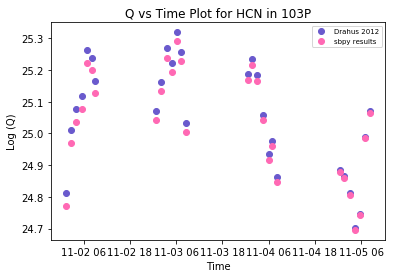

In [7]:
q_pred_hcn = list(hcn['log(Q)']) # literature production rates
print("The Literature Production Rates for HCN in {} using Drahus et al. 2012 model are:\n {}".format(target, np.round(q_pred_hcn,3))) 

time_hcn = list(hcn['Time'])
time_hcn = matplotlib.dates.datestr2num(time_hcn)

plt.plot_date(time_hcn, q_pred_hcn, 'o', color='slateblue', label='Drahus 2012')
plt.plot_date(time_hcn, q_found_hcn, 'o', color='hotpink', label='sbpy results')
plt.xlabel('Time')
plt.ylabel('Log (Q)')
plt.legend(loc='best', fontsize='x-small')
plt.title('Q vs Time Plot for HCN in {}'.format(target))
plt.show()

Calculate residuals between the data and the production rates obtained

The Residuals between sbpy results and literature are:
 [0.042 0.041 0.04  0.04  0.039 0.038 0.038 0.03  0.03  0.03  0.029 0.029
 0.028 0.027 0.019 0.019 0.018 0.017 0.017 0.017 0.016 0.009 0.007 0.007
 0.006 0.005 0.005 0.004]


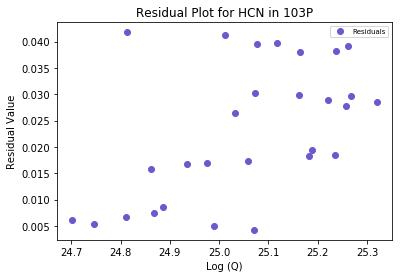

In [8]:
res_hcn = (np.array(q_pred_hcn)) - (np.array(q_found_hcn)) # calculate residuals

print("The Residuals between sbpy results and literature are:\n {}".format(np.round(res_hcn,3))) 

plt.plot(q_pred_hcn, res_hcn, 'o', color='slateblue', label='Residuals') # plot residuals
plt.xlabel('Log (Q)')
plt.ylabel('Residual Value')
plt.legend(loc='best', fontsize='x-small')
plt.title('Residual Plot for HCN in {}'.format(target))
plt.show()

During development, we reached out to the author to talk about the differences between our results and the paper's results. Some of the differences that came up were:
- The use of different catalogs (not only JPLSpec but also CDMS, LAMDA, etc.) for some of the data
- Author used a constant distance between the comet and the observer (constant delta)
- Einstein Coefficients were not calculated the same way
    - sbpy uses an equation obtained form JPLSpec documentation instead of the LAMDA catalog or other means

The errors for the production rate calculations within the literature were obtained from variations in the line profile area (integrated flux). The errors for the integrated flux were obtained in the following manner:

> *[...] errors were estimated from 500 simulations following our Monte Carlo approach, which we used to propagate the signal noise and also the uncertainty from imperfect pointing whenever relevant (see Paper I for details).* [(Drahus et al. 2012, pp. 6)](https://ui.adsabs.harvard.edu/abs/2012ApJ...756...80D/abstract)

Thus, the production rate errors derived for production rate in the literature are listed as the following:

In [9]:
print("Production rate error +\n{}\nProduction Rate error -\n{}\nResiduals from sbpy\n{}".format(list(hcn['error_top']), list(hcn['error_bottom']), np.round(res_hcn,3)))

Production rate error +
[0.081, 0.078, 0.078, 0.082, 0.077, 0.081, 0.087, 0.077, 0.079, 0.078, 0.084, 0.083, 0.08, 0.082, 0.077, 0.077, 0.081, 0.083, 0.085, 0.085, 0.087, 0.088, 0.078, 0.076, 0.082, 0.081, 0.084, 0.083]
Production Rate error -
[0.013, 0.007, 0.004, 0.004, 0.004, 0.007, 0.012, 0.008, 0.005, 0.004, 0.004, 0.004, 0.005, 0.005, 0.007, 0.005, 0.005, 0.005, 0.01, 0.009, 0.011, 0.013, 0.011, 0.009, 0.013, 0.015, 0.009, 0.015]
Residuals from sbpy
[0.042 0.041 0.04  0.04  0.039 0.038 0.038 0.03  0.03  0.03  0.029 0.029
 0.028 0.027 0.019 0.019 0.018 0.017 0.017 0.017 0.016 0.009 0.007 0.007
 0.006 0.005 0.005 0.004]


The residuals for sbpy are therefore well within range of the upper limit of error in the literature. 
The reality is that the results will always vary with the molecular data used, and the functions within sbpy 
that are used  (i.e. `einstein_coeff` vs LAMDA catalog Einstein Coefficients). Because of this, the module was 
designed in a flexible manner using `sbpy.data` instances, which allows the user to fully customize their data 
before calculating the production rate with whatever model they choose.

LTE `from_Drahus` Second Example (User-defined Data):
-------------------------------------------------------------------------------------------------------------

Load the data file containing values for time of observations, integrated flux, 
and error bars from the literature in order to obtain the 
information needed for the calculation of our production rates. It follows the same format at the table in the first example

In [10]:
ch3oh = Table.read('data/CH3OH.csv', format="ascii.csv")

Model parameters needed, all values are taken directly from the literature. In this example, the parameters are all the same as last example's except for our molecule and transition frequency. See [documentation](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#production-rate-calculations) for more information on the parameter values

In [11]:
mol_tag = 32003 # JPLSpec unique identifier

t_freq = (157.178987 * u.GHz).to('MHz')

In this example we will show how users can define and store their own molecular data in a phys object.
See the previous example for the use of from_jplspec to obtain the molecular data necessary for
production rate calculations. For more information on the molecular parameters needed see both `activity.productionrate` [module](https://sbpy.readthedocs.io/en/latest/sbpy/activity/index.html#production-rate-calculations) and `astroquery.jplspec` [module](https://astroquery.readthedocs.io/en/latest/jplspec/jplspec.html) documentation

In [12]:
lgint300 = 7.4336139*10**(-5) * u.MHz * u.nm * u.nm # integrated line intensity (300 K)

part300 = 9473.271845042498 # partition function (300 K)

partition = 308.5479509730844 # paritition function

gu = 11.0 # Upper state degeneracy

energy_J = 6.61822698*10**(-22) * u.J # Upper level energy

elo_J = 5.57674801*10**(-22) * u.J # Lower level energy

df = 3 # degrees of freedom

quantities = [t_freq, temp_estimate, lgint300, part300, partition, gu, energy_J,
              elo_J, df, mol_tag]

names = ['t_freq', 'temp', 'lgint300', 'partfn300', 'partfn',
         'dgup', 'eup_J', 'elo_J', 'degfreedom', 'mol_tag']

mol_data = Phys.from_dict(dict(zip(names, quantities))) # build the phys object

Obtaining the Einstein Coefficient, and integrated line intensity at a given temperature from the molecular data,
as explained in the first example. [This notebook](LTE_prodrate_Haser.ipynb) will show how to use a user-defined Einstein Coefficient.

In [13]:
intl = intensity_conversion(mol_data) # integrated line intensity

mol_data.apply([intl.value] * intl.unit,
                    name='intl') # store value

au = einstein_coeff(mol_data) # obtain Einstein Coefficient

mol_data.apply([au.value] * au.unit, name='eincoeff') # store value

In [14]:
lte = LTE() # initialize LTE class

q_found_ch3oh = [] # define empty list

for i in range(0, 20):

    time = Time(ch3oh['Time'][i], format='iso') # build astropy.time object
    
    integrated_flux = ch3oh['T_B'][i] * u.K * u.km / u.s # integrated flux 
    
    ephemobj = Ephem.from_horizons(target, epochs=time.jd, id_type='id') # create ephem object

    q = lte.from_Drahus(integrated_flux, mol_data, ephemobj, vgas, aper, b=b) # calculate production rate

    q = np.log10(q.value)

    q_found_ch3oh.append(q) # append production rate

print("The Resulting Production Rates for CH3OH in {} using Drahus et al. 2012 model are:\n {}".format(target, np.round(q_found_ch3oh,3)))

The Resulting Production Rates for CH3OH in 103P using Drahus et al. 2012 model are:
 [26.445 26.573 26.563 26.593 26.597 26.491 26.48  26.553 26.504 26.482
 26.463 26.423 26.354 26.477 26.349 26.399 26.31  26.325 26.401 26.556]


Plot production rates against time

The Literature Production Rates for CH3OH in 103P using Drahus et al. 2012 model are:
 [26.534 26.664 26.653 26.681 26.685 26.578 26.56  26.633 26.584 26.559
 26.541 26.5   26.432 26.545 26.42  26.467 26.375 26.394 26.467 26.623]


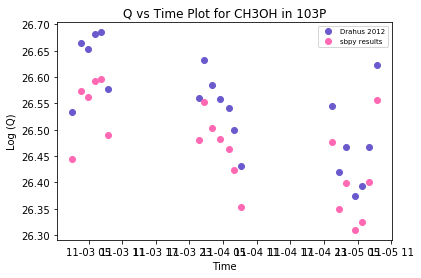

In [15]:
q_pred_ch3oh = list(ch3oh['log(Q)']) # literature production rates
print("The Literature Production Rates for CH3OH in {} using Drahus et al. 2012 model are:\n {}".format(target, np.round(q_pred_ch3oh,3))) 

time_ch3oh = list(ch3oh['Time'])
time_ch3oh = matplotlib.dates.datestr2num(time_ch3oh)

plt.plot_date(time_ch3oh, q_pred_ch3oh, 'o', color='slateblue', label='Drahus 2012')
plt.plot_date(time_ch3oh, q_found_ch3oh, 'o', color='hotpink', label='sbpy results')
plt.xlabel('Time')
plt.ylabel('Log (Q)')
plt.legend(loc='best', fontsize='x-small')
plt.title('Q vs Time Plot for CH3OH in {}'.format(target))
plt.show()

Calculate the residuals:

The Residuals between sbpy results and literature are:
 [0.042 0.041 0.04  0.04  0.039 0.038 0.038 0.03  0.03  0.03  0.029 0.029
 0.028 0.027 0.019 0.019 0.018 0.017 0.017 0.017 0.016 0.009 0.007 0.007
 0.006 0.005 0.005 0.004]


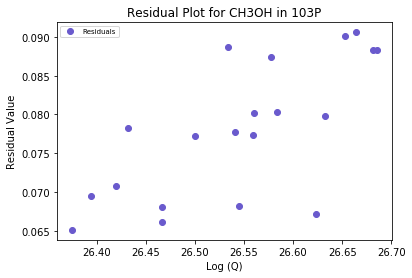

In [16]:
q_pred_ch3oh = list(ch3oh['log(Q)']) # literature production rates

res_ch3oh = (np.array(q_pred_ch3oh)) - (np.array(q_found_ch3oh)) # residuals

print("The Residuals between sbpy results and literature are:\n {}".format(np.round(res_hcn,3))) 

plt.plot(q_pred_ch3oh, res_ch3oh, 'o', color='slateblue', label='Residuals') # plot
plt.xlabel('Log (Q)')
plt.ylabel('Residual Value')
plt.legend(loc='best', fontsize='x-small')
plt.title('Residual Plot for CH3OH in {}'.format(target))
plt.show()

**Important:** the method used by the author for the CH3OH molecule was to test and average the molecular data for 5 different transition frequencies, the molecular data was also obtained from CDMS instead of JPLSpec. Because of these two key differences it is only natural that the difference between the literature and the calculated production rates in sbpy will be bigger than in the first example. If the user wishes to recreate more of the author's process, all that is needed is to
obtain `mol_data` for 5 the different transition frequency lines that the author used [in page 38 of Drahus et al. 2012](https://arxiv.org/pdf/1202.3194.pdf), and then to take the average of that molecular data and use it as the input data into the models. 

The errors from the literature along with sbpy residuals are shown below

In [17]:
print("Production rate error +\n{}\nProduction Rate error -\n{}\nResiduals from sbpy\n{}".format(list(ch3oh['error_top']), list(ch3oh['error_bottom']), np.round(res_ch3oh,3)))

Production rate error +
[0.4, 0.035, 0.036, 0.038, 0.037, 0.037, 0.045, 0.036, 0.035, 0.039, 0.041, 0.043, 0.043, 0.043, 0.041, 0.04, 0.046, 0.045, 0.043, 0.044]
Production Rate error -
[0.017, 0.009, 0.011, 0.012, 0.014, 0.015, 0.02, 0.015, 0.013, 0.014, 0.019, 0.016, 0.023, 0.021, 0.02, 0.019, 0.021, 0.022, 0.021, 0.016]
Residuals from sbpy
[0.089 0.091 0.09  0.088 0.088 0.087 0.08  0.08  0.08  0.077 0.078 0.077
 0.078 0.068 0.071 0.068 0.065 0.069 0.066 0.067]


Helpful Links
=======
___________________________________________

Relevant Notebooks
-----------------
- [How to calculate LTE production rates with Haser model](LTE_prodrate_Haser.ipynb)
- [How to calculate NonLTE production rates with Haser model](NonLTE_prodrate_Haser.ipynb)
- [How to use Phys data class and `from_jplspec`](../data/Phys.ipynb)
- [What is `astroquery.jplspec`](../data/jplspec.ipynb)

Relevant Links
-------------
- [LAMDA Queries with astroquery](https://astroquery.readthedocs.io/en/latest/lamda/lamda.html)
- [JPLSpec Queries with astroquery](https://astroquery.readthedocs.io/en/latest/jplspec/jplspec.html)
- [sbpy Activity Haser Class](https://sbpy.readthedocs.io/en/latest/api/sbpy.activity.Haser.html#sbpy.activity.Haser)
- [sbpy Ephem data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-ephem)
- [sbpy Phys data class](https://sbpy.readthedocs.io/en/latest/sbpy/data/index.html#how-to-use-phys)
- [sbpy data class alternative field names](https://sbpy.readthedocs.io/en/latest/sbpy/data/fieldnames.html#list-of-alternative-field-names)
- [pyradex source code](https://github.com/keflavich/pyradex)
- [RADEX fortran source code](https://personal.sron.nl/~vdtak/radex/)
- [RADEX homepage](https://personal.sron.nl/~vdtak/radex/index.shtml)
- [sbpy citation (please cite our work)](http://joss.theoj.org/papers/10.21105/joss.01426)